In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

overlap_df = pd.read_pickle("../datasets/overlap_results_with_road_distance3.pkl")
routes_pv_ft_df = pd.read_csv("../datasets/pv_eda/routes_pv_combined_ft.csv")
routes_pv_df = pd.read_csv("../datasets/pv_eda/routes_pv_combined.csv")

In [86]:
overlap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401 entries, 0 to 556
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ServiceNo              401 non-null    object 
 1   TotalBusStops          401 non-null    int64  
 2   AvgNormalizedDistance  401 non-null    float64
 3   SoftmaxAvgDistance     401 non-null    float64
 4   NormalizedDistances    401 non-null    object 
 5   Category               401 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 21.9+ KB


In [87]:
routes_pv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ServiceNo                  401 non-null    object 
 1   JulyTotalTapIn             401 non-null    float64
 2   JulyTotalTapOut            401 non-null    float64
 3   AugTotalTapIn              401 non-null    float64
 4   AugTotalTapOut             401 non-null    float64
 5   SepTotalTapIn              401 non-null    float64
 6   SepTotalTapOut             401 non-null    float64
 7   JulyTotalVolume            401 non-null    float64
 8   AugTotalVolume             401 non-null    float64
 9   SepTotalVolume             401 non-null    float64
 10  VolumeDecrease_Jul_to_Sep  401 non-null    float64
 11  NormalizedVolumeDecrease   401 non-null    float64
 12  SoftmaxVolumeDecrease      401 non-null    float64
dtypes: float64(12), object(1)
memory usage: 40.9+ KB


In [88]:
routes_pv_ft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ServiceNo                  401 non-null    object 
 1   JulyTotalTapIn             401 non-null    float64
 2   JulyTotalTapOut            401 non-null    float64
 3   AugTotalTapIn              401 non-null    float64
 4   AugTotalTapOut             401 non-null    float64
 5   SepTotalTapIn              401 non-null    float64
 6   SepTotalTapOut             401 non-null    float64
 7   JulyTotalVolume            401 non-null    float64
 8   AugTotalVolume             401 non-null    float64
 9   SepTotalVolume             401 non-null    float64
 10  VolumeDecrease_Jul_to_Sep  401 non-null    float64
 11  NormalizedVolumeDecrease   401 non-null    float64
 12  SoftmaxVolumeDecrease      401 non-null    float64
dtypes: float64(12), object(1)
memory usage: 40.9+ KB


### Model 1 : KNN Clustering

In [89]:
# Combine features from your three data tables
clustering_df = pd.merge(overlap_df[['ServiceNo', 'SoftmaxAvgDistance']],
                         routes_pv_df[['ServiceNo', 'SoftmaxVolumeDecrease']],
                         on='ServiceNo')
clustering_df = pd.merge(clustering_df,
                         routes_pv_ft_df[['ServiceNo', 'SoftmaxVolumeDecrease']],
                         on='ServiceNo')

# Rename columns for clarity
clustering_df.columns = ['ServiceNo', 'OverlappingDistance', 'PVDecrease', 'IntStnPVDecrease']

# Apply StandardScaler to standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_df[['OverlappingDistance', 'PVDecrease', 'IntStnPVDecrease']])


In [90]:
print(features_scaled)

[[-2.52361543e-04  1.06255516e+00  1.37056137e+00]
 [ 2.21186611e-01 -9.46063234e-02 -4.03138703e-02]
 [-1.82135238e-01 -6.66936420e-01 -6.01775839e-01]
 ...
 [-1.65188871e+00 -7.99983445e-01 -7.94897298e-01]
 [-4.30275079e-01 -3.30808011e-01 -2.05321615e-01]
 [-1.21958497e+00 -6.23807036e-01 -6.31870816e-01]]


In [91]:
knn_df = clustering_df.copy()
kmeans_3 = KMeans(n_clusters=3, random_state=42)
knn_df['Cluster'] = kmeans_3.fit_predict(features_scaled)

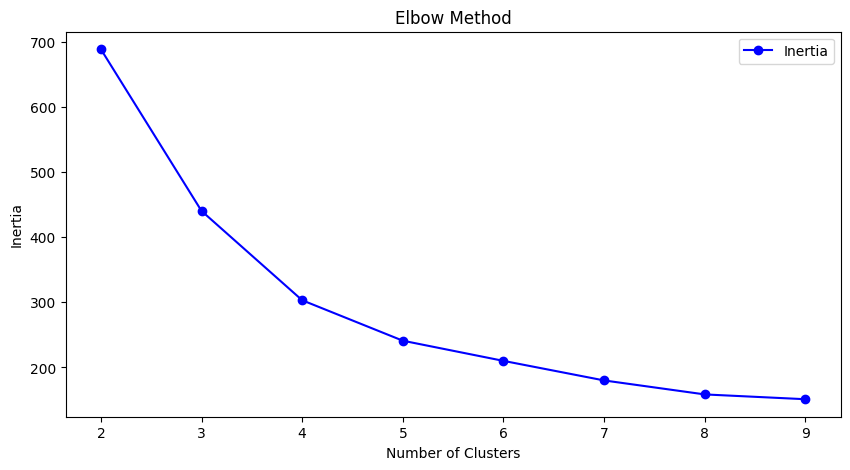

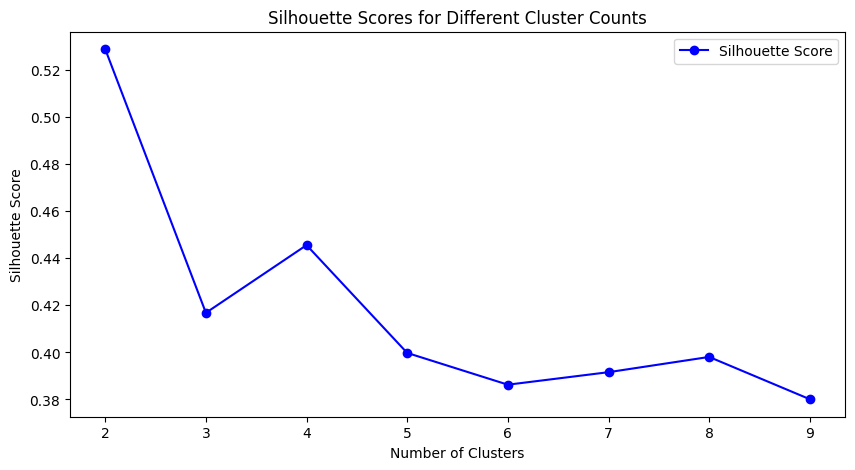

In [92]:
#Finding optimal K using elbow method and Silhouette Scores
inertia = []
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), inertia, 'bo-', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Cluster Counts')
plt.legend()
plt.show()

In [93]:
optimal_k = 2  # Based on elbow and silhouette methods
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
knn_df['Cluster'] = kmeans.fit_predict(features_scaled)

# Calculate Silhouette Score for the final model
final_silhouette_score = silhouette_score(features_scaled, knn_df['Cluster'])
print("Final Silhouette Score:", final_silhouette_score)

# Display centroids for interpretation
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['OverlappingDistance', 'PVDecrease', 'IntStnPVDecrease'])
print("Cluster Centroids:\n", centroids)


Final Silhouette Score: 0.5288580814318906
Cluster Centroids:
    OverlappingDistance  PVDecrease  IntStnPVDecrease
0            -0.009876   -0.341698         -0.343237
1             0.053999    1.868318          1.876731


In [94]:
optimal_k = 5  # Based on elbow and silhouette methods
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
knn_df['Cluster'] = kmeans.fit_predict(features_scaled)

# Calculate Silhouette Score for the final model
final_silhouette_score = silhouette_score(features_scaled, knn_df['Cluster'])
print("Final Silhouette Score:", final_silhouette_score)

# Display centroids for interpretation
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['OverlappingDistance', 'PVDecrease', 'IntStnPVDecrease'])
print("Cluster Centroids:\n", centroids)


Final Silhouette Score: 0.3997774535017588
Cluster Centroids:
    OverlappingDistance  PVDecrease  IntStnPVDecrease
0             0.310698   -0.434627         -0.421457
1             1.810277   -0.456806         -0.421275
2            -0.203187    3.245282          3.410647
3             0.020731    1.054986          0.890330
4            -0.945534   -0.441938         -0.400120


In [95]:
knn_df['Cluster'] = kmeans.labels_  # Add cluster labels to the DataFrame

# Filter for rows assigned to Cluster 3
redundant_routes_df = knn_df[knn_df['Cluster'] == 3]

# Display the filtered DataFrame
print(redundant_routes_df)

# Optionally, save the filtered bus routes to a CSV file for further review
# redundant_routes_df.to_csv('potential_redundant_bus_routes.csv', index=False)


    ServiceNo  OverlappingDistance  PVDecrease  IntStnPVDecrease  Cluster
0          10             0.001797    0.003092          0.003151        3
7         103             0.001642    0.002830          0.002756        3
8         105             0.001833    0.002929          0.003006        3
10        106             0.002068    0.002823          0.003215        3
31        118             0.001858    0.003384          0.002372        3
..        ...                  ...         ...               ...      ...
319        87             0.001799    0.003087          0.003147        3
355       963             0.001842    0.003193          0.003720        3
360       966             0.001750    0.002688          0.002873        3
387       985             0.001730    0.003169          0.002914        3
393       991             0.001757    0.003044          0.003290        3

[74 rows x 5 columns]


### Model 2 : Weighted Score

In [96]:
#  Apply PCA on scaled features
weighted_df = clustering_df.copy()
pca = PCA()
pca.fit(features_scaled)

# Step 3: Determine feature weights using the first principal component (PC1)
loadings = pca.components_
pc1_loadings = loadings[0]
feature_weights = abs(pc1_loadings) / sum(abs(pc1_loadings))
# Step 4: Calculate weighted scores
weighted_df['WeightedOverlappingDistance'] = weighted_df['OverlappingDistance'] * feature_weights[0]
weighted_df['WeightedPVDecrease'] = weighted_df['PVDecrease'] * feature_weights[1]
weighted_df['WeightedIntStnPVDecrease'] = weighted_df['IntStnPVDecrease'] * feature_weights[2]
weighted_df['FinalScore'] = weighted_df[['WeightedOverlappingDistance', 'WeightedPVDecrease', 'WeightedIntStnPVDecrease']].sum(axis=1)

# Step 5: Rank bus services based on scores
ranked_bus_services = weighted_df.sort_values(by='FinalScore', ascending=False)
print(ranked_bus_services)

    ServiceNo  OverlappingDistance  PVDecrease  IntStnPVDecrease  \
362       969             0.001720    0.005188          0.005646   
254        67             0.002022    0.005082          0.004815   
179        28             0.001822    0.005260          0.004580   
106       168             0.001701    0.004780          0.004649   
185        31             0.001827    0.004847          0.004542   
..        ...                  ...         ...               ...   
125       179             0.001805    0.001965          0.002157   
253        66             0.001630    0.002032          0.002077   
321       871             0.001630    0.001976          0.002102   
126      179A             0.001648    0.001935          0.002135   
366        97             0.001915    0.001945          0.002112   

     WeightedOverlappingDistance  WeightedPVDecrease  \
362                     0.000037            0.002538   
254                     0.000044            0.002486   
179            